### ライブラリ

In [1]:
import os
import math
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
#

In [2]:
from builder.build_optimizer import BuildOptimizer

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### ネットワーク

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        # x = F.log_softmax(x, dim=1)
        return x
# 

### データセット

In [4]:
def set_data(BS, data_seed, num_workers):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), # MNISTの平均
         (0.3081,))                     # 標準偏差
        ])

    # 乱数生成器の設定
    generator = torch.Generator()
    generator.manual_seed(data_seed)

    train_dataset = datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
        )

    test_dataset = datasets.MNIST(
        root='./data',
        train=False,
        transform=transform
        )

    train_loader = DataLoader(
        train_dataset,
        batch_size=BS,
        shuffle=True,
        num_workers=num_workers,
        generator = generator
        )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BS,
        shuffle=False,
        num_workers=num_workers,
        generator = generator
        )
    
    return train_loader, test_loader
# 


### 学習テスト関数

In [5]:
def iter_train(
        model,
        X,
        T,
        device, 
        optimizer, 
        criterion, 
        sched_name, 
        scheduler, 
        ):
    """
        1 iteration の処理
    """
    
    X, T = X.to(device), T.to(device) # データ、教師信号をデバイスに移動
    
    optimizer.zero_grad()   # 勾配のリセット
    Y = model(X)            # 順伝番
    loss = criterion(Y, T)  # 損失関数
    loss.backward()         # 逆伝番
    optimizer.step()

    # スケジューラ更新
    if scheduler is not None and ("OneCycle" in sched_name or "WarmupCosine" in sched_name):
        scheduler.step()
    
    """
        loss.item: イテレーションの平均損失(torch MSEの戻り値はmean reduction)
    """
    iter_loss = loss.item()                                        # イテレーションの合計損失
    iter_pred = Y.argmax(dim=1, keepdim=True)
    iter_correct = iter_pred.eq(T.view_as(iter_pred)).sum().item() # 正解率の計算
    iter_total = T.size(0)                                         # バッチサイズ
    current_lrs = optimizer.param_groups[0]["lr"]            # 学習率
    
    return iter_loss, iter_correct, iter_total, current_lrs

def train_epoch(
        model, 
        device, 
        train_loader, 
        optimizer,
        sched_name, 
        criterion,
        scheduler, 
        ):
    """
        1 epoch の処理
    """
    model.train()

    if hasattr(optimizer, 'train'):
        optimizer.train()

    epoch_loss = 0
    epoch_correct = 0
    epoch_total = 0
    lrs_in_epoch = []   # イテレーションごとの学習率を保存

    for idx, (X, T) in enumerate(train_loader):
        iter_loss, iter_correct, iter_total, current_lrs = iter_train(
            model,
            X,
            T,
            device, 
            optimizer, 
            criterion, 
            sched_name, 
            scheduler, 
            )
        
        epoch_loss += iter_loss
        epoch_correct += iter_correct
        epoch_total += iter_total
        lrs_in_epoch.append(current_lrs)
    
    if scheduler is not None and not ("OneCycle" in sched_name or "WarmupCosine" in sched_name):
        scheduler.step()

    avg_epoch_loss = epoch_loss / len(train_loader)
    epoch_accuracy = 100. * epoch_correct / epoch_total
    current_epoch_lrs = optimizer.param_groups[0]["lr"] # 学習率

    return avg_epoch_loss, epoch_accuracy, lrs_in_epoch, current_epoch_lrs
# 

In [6]:
def test_iter(
        model, 
        X, 
        T, 
        device, 
        criterion,
        ):
    """
    1イテレーションごとの評価処理
    """
    X, T = X.to(device), T.to(device)
    with torch.no_grad():
        Y = model(X)
        loss = criterion(Y, T)

        iter_loss = loss.item()
        iter_pred = Y.argmax(dim=1, keepdim=True)
        iter_correct = iter_pred.eq(T.view_as(iter_pred)).sum().item()
        iter_total = T.size(0)   # ←バッチサイズだけカウント

    return iter_loss, iter_correct, iter_total


def test_epoch(
        model, 
        optimizer, 
        test_loader, 
        device, 
        criterion
        ):
    """
    エポック単位の評価処理
    """
    model.eval()

    if hasattr(optimizer, 'eval'):
        optimizer.eval()

    epoch_loss = 0
    epoch_correct = 0
    epoch_total = 0

    for X, T in test_loader:
        iter_loss, iter_correct, iter_total, = test_iter(
            model,
            X, 
            T, 
            device, 
            criterion,
        )
        epoch_loss += iter_loss
        epoch_correct += iter_correct
        epoch_total += iter_total

    avg_epoch_loss = epoch_loss / len(test_loader)
    epoch_accuracy = 100.0 * epoch_correct / epoch_total

    return avg_epoch_loss, epoch_accuracy
# 

### メインループ

In [7]:
LRs = [0.001]
# BSs = [2048, 1024, 512, 256, 32, 16]
BSs = [2048]
EPOCHS = 3
num_workers = 4
model_seed = 42
data_seed = 42

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

model = Net()
pth_name = f'initial_weights_FC_seed={model_seed}.pth'
torch.save(model.state_dict(), pth_name)

for BS in BSs:

    results = []  # 各バッチサイズごとの、すべての最適化手法の結果を保存

    for LR in LRs:
        
        train_loader, test_loader = set_data(BS, data_seed, num_workers)
        steps_per_epoch = len(train_loader)  # 1エポックあたりのステップ数

        # 各最適化手法ごとにループ
        for optm_name in [
            "Adam", 
            "Adam+StepLR", 
            "Adam+MultiStepLR",
            "Adam+ExponentialLR", 
            "Adam+CosineAnnealing",
            "Adam+OneCycleLR", 
            "Adam+WarmupCosine",
            "Schedule-Free Adam",
            "ADINA",
            "ADINA+StepLR", 
            "ADINA+MultiStepLR",
            "ADINA+ExponentialLR", 
            "ADINA+CosineAnnealing",
            "ADINA+OneCycleLR", 
            "ADINA+WarmupCosine",
            "Schedule-Free ADINA",
            "Schedule-Free ADINA Approx",
            "Schedule-Free ADINA LRC",
            ]:

            # モデルインスタンスを生成
            model = Net()
            model.load_state_dict(torch.load(pth_name))
            model.to(device)

            # モデルに対応した optimizer/scheduler を構築
            builder = BuildOptimizer(
                model,
                lr=LR,
                total_epochs=EPOCHS,
                steps_per_epoch=steps_per_epoch,
                )
            optimizer, scheduler, sched_name = builder.build_optimizers_and_schedulers()[optm_name]

            criterion = nn.CrossEntropyLoss()

            # 各手法の訓練損失、訓練精度、テスト損失、テスト精度, 学習率を保存する配列
            train_losses, train_accuracies = [], []
            test_losses, test_accuracies = [], []
            train_epoch_lrs, train_iter_lrs = [], []

            # --- ０回目のテストケース計算 ---
            epoch_test_loss, epoch_test_accuracy = test_epoch(
                model,
                optimizer,
                test_loader,
                device,
                criterion,
            )
            test_losses.append(epoch_test_loss)
            test_accuracies.append(epoch_test_accuracy)

            # 学習
            for epoch in range(1, EPOCHS + 1):

                # --- train ---
                epoch_train_loss, epoch_train_accuracy, lrs_in_epoch, current_epoch_lrs = train_epoch(
                    model,
                    device,
                    train_loader,
                    optimizer,
                    sched_name,
                    criterion,
                    scheduler,
                )
                train_losses.append(epoch_train_loss)
                train_accuracies.append(epoch_train_accuracy)
                train_epoch_lrs.append(current_epoch_lrs)
                train_iter_lrs.append(lrs_in_epoch)

                # --- test ---
                epoch_test_loss, epoch_test_accuracy = test_epoch(
                    model,
                    optimizer,
                    test_loader,
                    device,
                    criterion,
                )
                test_losses.append(epoch_test_loss)
                test_accuracies.append(epoch_test_accuracy)
                
            result_entry = {
                'seed': model_seed,
                'batch_size': BS,
                'learning_rate': LR,
                'optimizer': optm_name,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'test_losses': test_losses,
                'test_accuracies': test_accuracies,
                'epoch_lrs': train_epoch_lrs,
                'iter_lrs': train_iter_lrs,
            }

            print(f'optim: {optm_name}, loss: {test_losses}')

            results.append(result_entry)

    # 各バッチサイズごとの結果をJSONへ保存
    filename = f'results_FC3_BS={BS}_seed={model_seed}.json'
    with open(filename, 'w') as f:
        json.dump(results, f, indent=4)



cpu
optim: Adam, loss: [2.323708343505859, 0.4384290039539337, 0.29265589118003843, 0.2502393782138824]
optim: Adam+StepLR, loss: [2.323708343505859, 0.4415296733379364, 0.3003025263547897, 0.2490019679069519]
optim: Adam+MultiStepLR, loss: [2.323708343505859, 0.43545626997947695, 0.29412630796432493, 0.24842360317707063]
optim: Adam+ExponentialLR, loss: [2.323708343505859, 0.434449827671051, 0.2996985524892807, 0.25797899067401886]
optim: Adam+CosineAnnealing, loss: [2.323708343505859, 0.4306528985500336, 0.31315030753612516, 0.2923267990350723]
optim: Adam+OneCycleLR, loss: [2.323708343505859, 0.7296789884567261, 0.33320254385471343, 0.31510740518569946]
optim: Adam+WarmupCosine, loss: [2.323708343505859, 2.0497000217437744, 0.8998337626457215, 0.39577884078025816]
Switching to train mode
Switching to eval mode
Switching to train mode
Switching to eval mode
Switching to train mode
Switching to eval mode
optim: Schedule-Free Adam, loss: [2.323708343505859, 0.6309307932853698, 0.360671

### 結果の表示

In [8]:
import matplotlib.pyplot as plt
import json
import typing

In [9]:
# plt.plot(x, y, color='r')   # red
# plt.plot(x, y, color='b')   # blue
# plt.plot(x, y, color='g')   # green
# plt.plot(x, y, color='k')   # black
# plt.plot(x, y, color='c')   # cyan
# plt.plot(x, y, color='m')   # magenta
# plt.plot(x, y, color='y')   # yellow
# plt.plot(x, y, color='w')   # white

# スタイル設定
style_map = {
    """ --- Adam --- """
    'Adam': {
        'color': 'b', 
        'linestyle': '--'
    },
    'Schedule-Free Adam': {
        'color': 'r', 
        'linestyle': '--'
    },
    # 'Schedule-Free AdamW closure': {
    #     'color': 'r', 
    #     'linestyle': '--'
    # },
    'Adam+StepLR': {
        'color': 'g', 
        'linestyle': '--'
    },
    'Adam+MultiStepLR': {
        'color': 'k', 
        'linestyle': '--'
    },
    'Adam+ExponentialLR': {
        'color': 'c', 
        'linestyle': '--'
    },
    'Adam+CosineAnnealing': {
        'color': 'm', 
        'linestyle': '--'
    },
    'Adam+OneCycleLR': {
        'color': 'y', 
        'linestyle': '--'
    },
    'Adam+WarmupCosine': {
        'color': 'w', 
        'linestyle': '--'
    },
    
    """ --- ADINA --- """
    'ADINA': {
        'color': 'b', 
        'linestyle': '-'
    },
    'Schedule-Free ADINA': {
        'color': 'r', 
        'linestyle': '-'
    },
    # 'Schedule-Free ADINA(λ=0)': {
    #     'color': 'orange', 
    #     'linestyle': '-'
    # },
    # 'Schedule-Free ADINA(λ=1)': {
    #     'color': 'pink', 
    #     'linestyle': '-'
    # },
    'Schedule-Free ADINA Approx': {
        'color': 'b', 
        'linestyle': '-.'
    },
    'Schedule-Free ADINA LRC': {
        'color': 'r', 
        'linestyle': '-.'
    },
    'ADINA+StepLR': {
        'color': 'g', 
        'linestyle': '-'
    },
    'ADINA+MultiStepLR': {
        'color': 'k', 
        'linestyle': '-'
    },
    'ADINA+ExponentialLR': {
        'color': 'c', 
        'linestyle': '-'
    },
    'ADINA+CosineAnnealing': {
        'color': 'm', 
        'linestyle': '-'
    },
    'ADINA+OneCycleLR': {
        'color': 'y', 
        'linestyle': '-'
    },
    'ADINA+WarmupCosine': {
        'color': 'w', 
        'linestyle': '-'
    },

    # '': {'color': '', 'linestyle': ''},
}



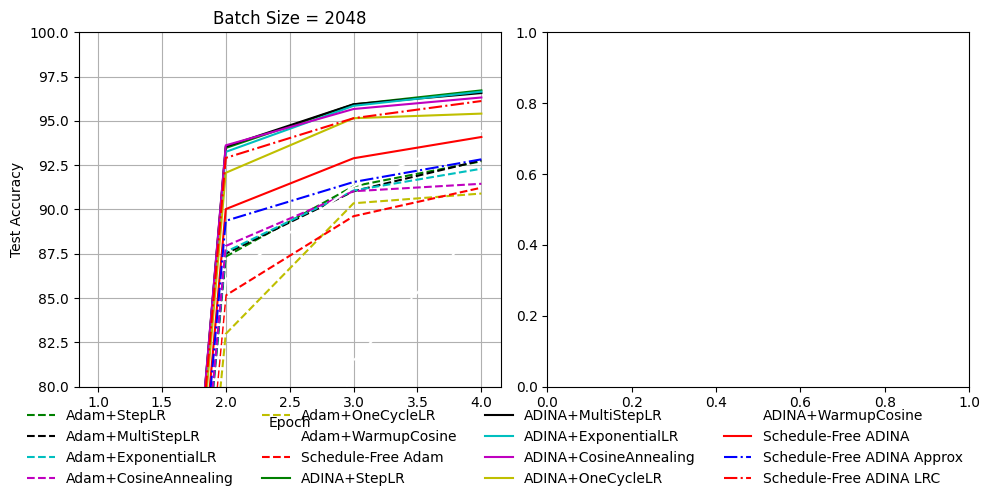

In [ ]:
# BSs = [2048, 1024, 512, 64, 32, 16]
# fig, axes = plt.subplots(3, 2, figsize=(10, 15))
BSs = [2048]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes = axes.flatten()


# 凡例用に線の情報を保存しておく
legend_handles = []

for i, BS in enumerate(BSs):
    ax = axes[i]
    pass_name = f''
    with open(pass_name, 'r') as f:
        results = json.load(f)

    for entry in results:
        optimizer = entry['optimizer']

        if optimizer not in style_map:
            continue

        test_acc = entry['test_accuracies']
        epochs = list(range(1, len(test_acc) + 1))
        style = style_map[optimizer]

        if optimizer == 'Schedule-Free ADINA(λ=0)':
            optimizer = 'Polyak-Ruppert Ave. ADINA'
        elif optimizer == 'Schedule-Free ADINA(λ=1)':
            optimizer = 'Primal Ave. ADINA'

        line, = ax.plot(
            epochs,
            test_acc,
            label=optimizer,
            color=style['color'],
            linestyle=style['linestyle'],
            linewidth=style.get('linewidth', 1.5)
        )

        # 1回目だけ凡例に追加（重複防止）
        if i == 0:
            legend_handles.append(line)

    ax.set_title(f'Batch Size = {BS}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Test Accuracy')
    ax.set_ylim(80, 100)
    ax.grid(True)

# 下中央にまとめて凡例を表示
fig.legend(handles=legend_handles, loc='lower center', ncol=4, fontsize=10, frameon=False)

# 下部を空けて配置調整
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()